## GPU acceleration

In this part we will use PyCuda to accelerate the computation of our automata.

### Installation

On ubuntu 14.04 amd64 with an NVIDIA Quadro 600.
First I installed CUDA by following the instructions in this website and it worked perfectly [link](http://www.r-tutor.com/gpu-computing/cuda-installation/cuda7.0-ubuntu).



`
$lsb_release -a
Distributor ID:	Ubuntu
Description:	Ubuntu 14.04.2 LTS
Release:	14.04
Codename:	trusty
`

`
glxinfo | grep direct
glxinfo | grep OpenGL
`

The sudo pip3 install pycuda

In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda.compiler import SourceModule

ImportError: No module named 'pycuda'

TODO import previous notebook but now we use booleans

In [2]:
class GameOfLife(object):
    def __init__(self,shape):
        self.shape = shape
        self.reset()
        self.init_cuda()
        
    def reset(self):
        self.array = np.random.randint(0,2,(self.shape)).astype(np.bool_)
        
        
    def run(self,nbIteration=1):
        for i in range(nbIteration):
            self.array = self.iterate(self.array)
                
    def init_cuda(self):
        mod = SourceModule("""
        __global__ void bit_gol(bool *dest, bool *a,
            const unsigned int nbRow,const unsigned int nbCol)
        {

            unsigned int x = threadIdx.x;
            unsigned int y = threadIdx.y;
            const unsigned int i = x + y*nbCol;
            unsigned int N;

            if(x > 0 && y > 0 && x < nbCol-1 && y < nbRow-1){
                N = ( a[x-1 + (y-1)*nbCol] + a[x + (y-1)*nbCol] + a[x+1 + (y-1)*nbCol] +
                      a[x-1 + ( y )*nbCol] +                    + a[x+1 + ( y )*nbCol] +
                      a[x-1 + (y+1)*nbCol] + a[x + (y+1)*nbCol] + a[x+1 + (y+1)*nbCol] );
            }else{
                N = 0;
            }

            dest[i] = (a[i] & (((N==2) | (N==3)))) /*survive*/
                      | (!a[i] & N==3);          /*birth*/

        }
        """)

        self.cuda_func = mod.get_function("bit_gol")
    
    def iterate(self,array):
        Y = np.zeros_like(array)
        nbRow = np.uint32(self.shape[0])
        nbCol = np.uint32(self.shape[1])

        self.cuda_func(
                drv.Out(Y), drv.In(array),nbRow,nbCol,
                block=(self.shape[0],self.shape[1],1), grid=(1,1))
        return Y


In [3]:
import unittest
import numpy.testing as npt
class TestGameOfLife(unittest.TestCase):
    def setUp(self):
        self.shape = (6,6)
        self.uut = GameOfLife(self.shape)
        
    def testUpdate(self):
        a = np.array([
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,1,1,1,0],
                [0,1,1,1,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(np.bool_)
        self.uut.array = a
        b = np.array([
                [0,0,0,0,0,0],
                [0,0,0,1,0,0],
                [0,1,0,0,1,0],
                [0,1,0,0,1,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(np.bool_)
        
        self.uut.run()
        npt.assert_equal(self.uut.array,b)
        self.uut.run()
        npt.assert_equal(self.uut.array,a)

In [4]:
import sys
def runGOFTest():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestGameOfLife)
    unittest.TextTestRunner().run(suite)


In [5]:
runGOFTest()

.
----------------------------------------------------------------------
Ran 1 test in 0.481s

OK


In [6]:
size = 30
uut = GameOfLife((size,size))
%timeit uut.run(100)

10 loops, best of 3: 39.1 ms per loop


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [8]:
def plotArray(array):
    X = np.copy(array)
    plt.imshow(X,cmap='gray_r',interpolation='none')
    
def plotIterations(gof,nbIteration=1):
    for i in range(nbIteration):
        if i != 0:
            uut.run()
            
        plt.subplot(100 + nbIteration*10+i+1)
        plotArray(uut.array)
        plt.xticks([])
        plt.yticks([])

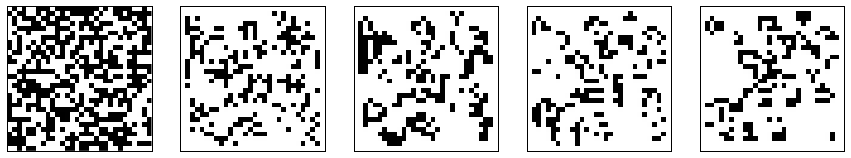

In [9]:
shape = (30,30)
uut = GameOfLife(shape)
plotIterations(uut,5)

Seems great but the size is a bit small. Let's try to rise it using different blocks.

In [15]:
def init_cuda(self):
    mod = SourceModule("""
            __global__ void bit_gol2(bool *dest, bool *a)
            {

                unsigned int x =  blockIdx.x*blockDim.x + threadIdx.x;
                unsigned int y =  blockIdx.y*blockDim.y + threadIdx.y;
                unsigned int nbRow = blockDim.y*gridDim.y;
                unsigned int nbCol = blockDim.x*gridDim.x;
                const unsigned int i = x + y*nbCol;
                unsigned int N;

                if(x > 0 && y > 0 && x < nbCol-1 && y < nbRow-1){
                    N = ( a[x-1 + (y-1)*nbCol] + a[x + (y-1)*nbCol] + a[x+1 + (y-1)*nbCol] +
                          a[x-1 + ( y )*nbCol] +                    + a[x+1 + ( y )*nbCol] +
                          a[x-1 + (y+1)*nbCol] + a[x + (y+1)*nbCol] + a[x+1 + (y+1)*nbCol] );
                }else{
                    N = 0;
                }

                dest[i] = (a[i] & (((N==2) | (N==3)))) 
                          | (!a[i] & N==3);            
                

            }
            """)

    self.cuda_func = mod.get_function("bit_gol2")
    
    self.blockSizeX = 30
    self.blockSizeY = 30
    self.nBlocksX = self.shape[1]//self.blockSizeX + (0 if self.shape[1]%self.blockSizeX == 0 else 1);
    self.nBlocksY = self.shape[0]//self.blockSizeY + (0 if self.shape[0]%self.blockSizeY == 0 else 1);


GameOfLife.init_cuda = init_cuda

In [16]:
def iterate(self,array):   
    Xtmp = np.zeros((self.blockSizeY*self.nBlocksY,self.blockSizeX*self.nBlocksX)).astype(array.dtype)
    Xtmp[0:self.shape[0],0:self.shape[1]] = array
    Ytmp = np.zeros_like(Xtmp)
    
    self.cuda_func(
            drv.Out(Ytmp), drv.In(Xtmp),
            block=(self.blockSizeX,self.blockSizeY,1), grid=(self.nBlocksX,self.nBlocksY))
    Y = Ytmp[0:self.shape[0],0:self.shape[1]]

    return Y

GameOfLife.iterate = iterate


In [17]:
runGOFTest()

.
----------------------------------------------------------------------
Ran 1 test in 3.025s

OK


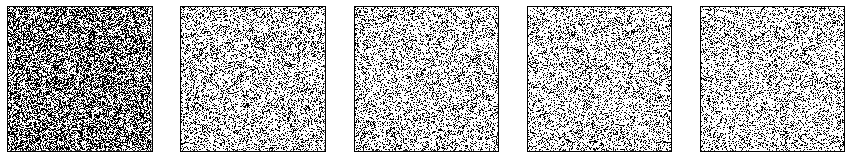

In [18]:
shape = (2000,2000)
uut = GameOfLife(shape)
plotIterations(uut,5)

In [19]:
uut = GameOfLife((1000,1000))
%timeit uut.run()


100 loops, best of 3: 5.19 ms per loop


The speed increade by a factor 2 only. This is quite disapointing.

Using the profiler tool nvprof it is possible to get leads for optimization: here we dont 
